In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import massspecgym.utils as utils
from pandarallel import pandarallel
from matchms.importing import load_from_mgf
from tqdm import tqdm
tqdm.pandas()
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula, CalcExactMolWt
utils.init_plotting(figsize=(4, 4))
%reload_ext autoreload
%autoreload 2

In [2]:
df_1M = pd.read_csv(utils.hugging_face_download('MassSpecGym_candidate_molecules.tsv'), sep='\t')
df_1M.shape, df_1M.columns

((1032456, 5),
 Index(['smiles', 'inchi_key_2D', 'inchi', 'formula', 'weight'], dtype='object'))

In [4]:
df_4M = pd.read_csv(utils.hugging_face_download('MassSpecGym_unlabeled_molecules.tsv'), sep='\t')
df_4M.shape, df_4M.columns

((3891780, 4),
 Index(['smiles', 'inchikey', 'weight', 'formula'], dtype='object'))

In [5]:
spectra = list(load_from_mgf(utils.hugging_face_download('MassSpecGym_labeled_data.mgf')))
smiles = pd.Series([s.metadata['smiles'] for s in spectra])
smiles = smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
smiles = smiles.drop_duplicates()
len(spectra), len(smiles)

(448979, 37151)

In [9]:
smiles_std = pd.Series(utils.standardize_smiles(smiles.tolist()))
len(smiles_std), len(smiles_std.dropna()), len(smiles_std.drop_duplicates())

In [35]:
def get_candidates(query_smiles, df, cand_type='formula'):
    candidates = {}
    n_queries_absent_in_db = 0
    for s in tqdm(query_smiles):
        if cand_type == 'formula':
            formula = CalcMolFormula(Chem.MolFromSmiles(s))
            candidates[s] = df['smiles'][df['formula'] == formula].tolist()
        elif cand_type == 'mass':
            mass = CalcExactMolWt(Chem.MolFromSmiles(s))
            mass_eps = mass * 1e-6 * 10  # 10 ppm
            candidates[s] = df['smiles'][(df['weight'] - mass).abs() < mass_eps].tolist()
        else:
            raise ValueError(f'Unknown candidates type {cand_type}.')

        if s not in candidates[s]:
            n_queries_absent_in_db += 1
            candidates[s].append(s)
    print('Number of queries absent in the database:', n_queries_absent_in_db)
    return candidates

In [13]:
cands_formula_1M = get_candidates(smiles, df_1M, cand_type='formula')

100%|██████████| 37151/37151 [20:34<00:00, 30.10it/s]

Number of queries absent in the database: 36572


In [14]:
cands_formula_4M = get_candidates(smiles, df_4M, cand_type='formula')

100%|██████████| 37151/37151 [1:15:29<00:00,  8.20it/s]

Number of queries absent in the database: 37151


In [36]:
cands_mass_1M = get_candidates(smiles, df_1M, cand_type='mass')
cands_mass_4M = get_candidates(smiles, df_4M, cand_type='mass')

100%|██████████| 37151/37151 [01:06<00:00, 562.49it/s]


Number of queries absent in the database: 36528


100%|██████████| 37151/37151 [04:18<00:00, 143.55it/s]

Number of queries absent in the database: 37151


In [130]:
num_cands_df = []
for cands, db_name, cand_type in [(cands_formula_1M, '1M', 'Formula'), (cands_formula_4M, '4M', 'Formula'), (cands_mass_1M, '1M', 'Mass'), (cands_mass_4M, '4M', 'Mass')]:
    num_cands_df.append(pd.DataFrame({
        'Num. candidates': [len(cands[s]) - 1 for s in smiles],
        'Database': db_name,
        'Type': cand_type
    }))
num_cands_df = pd.concat(num_cands_df)
num_cands_df

,Num. candidates,Database,Type
0,89,1M,Formula
1,101,1M,Formula
2,24,1M,Formula
3,20,1M,Formula
4,15,1M,Formula
...,...,...,...
37146,629,4M,Mass
37147,98,4M,Mass
37148,1295,4M,Mass
37149,850,4M,Mass


<Axes: xlabel='Database', ylabel='Num. candidates'>

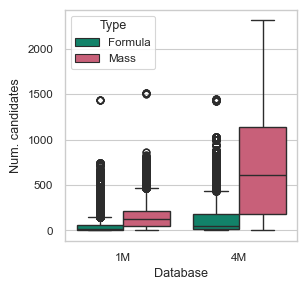

In [163]:
utils.init_plotting(figsize=(3, 3))
sns.boxplot(data=num_cands_df, x='Database', y='Num. candidates', hue='Type')

In [160]:
df_cands_at_k = []
for k in [1, 5, 10, 20]:
    for d in num_cands_df['Database'].unique():
        for t in num_cands_df['Type'].unique():
            df_subset = num_cands_df[(num_cands_df['Database'] == d) & (num_cands_df['Type'] == t)]
            df_cands_at_k.append({
                'Num. candidates < k [%]': (df_subset['Num. candidates'] < k).sum() / len(df_subset) * 100,
                'Database': d,
                'Type': t,
                'k': k
            })
df_cands_at_k = pd.DataFrame(df_cands_at_k)
df_cands_at_k

,Num. candidates < k [%],Database,Type,k
0,6.355145,1M,Formula,1
1,0.398374,1M,Mass,1
2,6.373987,4M,Formula,1
3,0.309548,4M,Mass,1
4,28.346478,1M,Formula,5
5,2.624425,1M,Mass,5
6,16.260666,4M,Formula,5
7,1.491212,4M,Mass,5
8,39.646308,1M,Formula,10
9,5.684908,1M,Mass,10


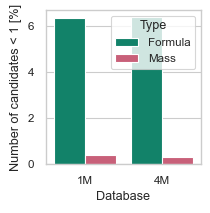

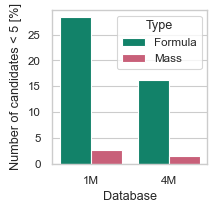

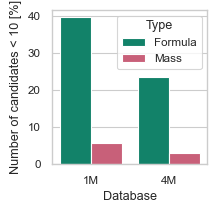

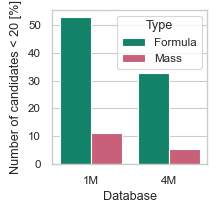

In [161]:
utils.init_plotting(figsize=(2, 2))
for k in df_cands_at_k['k'].unique():
    sns.barplot(data=df_cands_at_k[df_cands_at_k['k'] == k], x='Database', y='Num. candidates < k [%]', hue='Type', hue_order=['Formula', 'Mass'])
    plt.ylabel(f'Number of candidates < {k} [%]')
    plt.show()

100%|██████████| 37151/37151 [17:06<00:00, 36.19it/s] 


<Axes: ylabel='Count'>

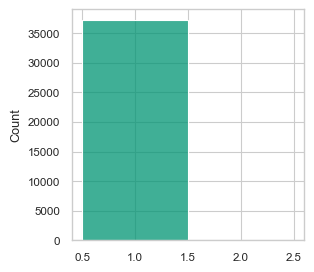

In [180]:
def smiles_to_inchi2d(smiles):
    return Chem.MolToInchiKey(Chem.MolFromSmiles(smiles)).split('-')[0]

num_cands_same_inchi = []
for k, v in tqdm(cands_formula_4M.items()):
    k_inchi = smiles_to_inchi2d(k)
    num_cands_same_inchi.append(sum([smiles_to_inchi2d(s) == k_inchi for s in v]))
num_cands_same_inchi = pd.Series(num_cands_same_inchi)
sns.histplot(num_cands_same_inchi, discrete=True)

In [164]:
with open('../../data/candidates_formula_1M.json', 'w') as f:
    json.dump(cands_formula_1M, f)
with open('../../data/candidates_formula_4M.json', 'w') as f:
    json.dump(cands_formula_4M, f)
with open('../../data/candidates_mass_1M.json', 'w') as f:
    json.dump(cands_mass_1M, f)
with open('../../data/candidates_mass_4M.json', 'w') as f:
    json.dump(cands_mass_4M, f)